In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight


In [2]:
def parse_spectrogram_and_metadata(melspec_path, split_path, metadata_path):
    # Load mel spectrograms
    melspec_dict = np.load(melspec_path, allow_pickle=True).item()

    # Load split and label info
    split_df = pd.read_csv(split_path)
    split_df['key'] = split_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    split_df = split_df.set_index('key')

    # Load downsampled metadata
    meta_df = pd.read_csv(metadata_path)
    meta_df['key'] = meta_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    meta_df = meta_df.set_index('key')

    X_img, X_meta, y, splits = [], [], [], []

    for key in meta_df.index:
        if key not in melspec_dict or key not in split_df.index:
            continue

        img = melspec_dict[key]
        info = split_df.loc[key]
        meta_row = meta_df.loc[key]

        metadata = np.array([
            float(meta_row['latitude']),
            float(meta_row['longitude']),
            float(meta_row['call']),
            float(meta_row['song/canto'])
        ], dtype=np.float32)

        X_img.append(img)
        X_meta.append(metadata)
        y.append(info['y_species_encoded'])
        splits.append(info['split'])

    return np.array(X_img), np.array(X_meta), np.array(y), np.array(splits)


In [3]:
def split_data(X_img, X_meta, y, splits):
    split_map = defaultdict(lambda: ([], [], []))

    for i, split in enumerate(splits):
        split_map[split][0].append(X_img[i])
        split_map[split][1].append(X_meta[i])
        split_map[split][2].append(y[i])

    def to_np(t): return tuple(map(np.array, t))
    return {k: to_np(v) for k, v in split_map.items()}

In [4]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf

def build_cnn_with_metadata(input_shape_img, input_shape_meta, num_classes):
    input_img = layers.Input(shape=input_shape_img, name='spectrogram')

    # Conv Block 1
    x = layers.Conv2D(32, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # Conv Block 2 + Residual
    res = layers.Conv2D(64, (1, 1), padding='same')(x)
    res = layers.MaxPooling2D((2, 2))(res)

    x = layers.Conv2D(64, (3, 3), padding='same',
                    kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Add()([x, res])  
    x = layers.SpatialDropout2D(0.3)(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Metadata input
    input_meta = layers.Input(shape=input_shape_meta, name='metadata')
    m = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(input_meta)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.3)(m)

    # Soft attention over metadata
    attention = layers.Dense(64, activation='sigmoid')(m)
    m = layers.Multiply()([m, attention])

    m = layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(m)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.3)(m)

    # Merge
    combined = layers.Concatenate()([x, m])
    z = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.5)(z)

    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.3)(z)

    output = layers.Dense(num_classes, activation='softmax')(z)

    model = models.Model(inputs=[input_img, input_meta], outputs=output)

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.9
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    return model


In [5]:
def add_random_noise(mels, noise_factor=0.05):
    noise = noise_factor * np.random.randn(*mels.shape)
    return np.clip(mels + noise, 0.0, 1.0)

def time_mask(spec, max_width=8):
    t = np.random.randint(0, spec.shape[1] - max_width)
    width = np.random.randint(1, max_width)
    spec[:, t:t+width] = 0
    return spec

def freq_mask(spec, max_height=4):
    f = np.random.randint(0, spec.shape[0] - max_height)
    height = np.random.randint(1, max_height)
    spec[f:f+height, :] = 0
    return spec

In [6]:
X_img, X_meta, y, splits = parse_spectrogram_and_metadata(
    melspec_path='../../data/raw/32/birdclef2025_melspec_5sec_32_32.npy',
    split_path='../../data/preprocessed/work_df_w_split_info.csv',
    metadata_path='../../data/downsampled_metadata.csv'
)

data_splits = split_data(X_img, X_meta, y, splits)

X_train_img, X_train_meta, y_train = data_splits['train']
X_val_img, X_val_meta, y_val = data_splits['val']
X_test_img, X_test_meta, y_test = data_splits['test']

# Add channel dimension to spectrograms
X_train_img = X_train_img[..., np.newaxis]  # becomes (259, 32, 32, 1)
X_val_img = X_val_img[..., np.newaxis]
X_test_img = X_test_img[..., np.newaxis]

X_train_img = X_train_img.astype(np.float32)
X_val_img = X_val_img.astype(np.float32)
X_test_img = X_test_img.astype(np.float32)

X_train_meta = X_train_meta.astype(np.float32)
X_val_meta = X_val_meta.astype(np.float32)
X_test_meta = X_test_meta.astype(np.float32)

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print(X_train_img.shape)  # --> (N, 32, 32, 1)
print(X_train_meta.shape) # --> (N, 4)
print(y_train.shape)      # --> (N,)

model = build_cnn_with_metadata(
    input_shape_img=X_train_img.shape[1:],  # e.g., (32, 32, 1)
    input_shape_meta=(X_train_meta.shape[1],),  # e.g., (4,)
    num_classes=len(np.unique(y))
)

model.summary()


(259, 32, 32, 1)
(259, 4)
(259,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        320 │ spectrogram[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     18,496 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata            │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      2,112 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        320 │ metadata[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 64)  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ max_pooling2d_2[… │
│                     │                   │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 132,260 (516.64 KB)

 Trainable params: 131,364 (513.14 KB)

 Non-trainable params: 896 (3.50 KB)

In [7]:
num_classes = len(np.unique(y_train))

y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)


In [8]:
scaler = StandardScaler()
X_train_meta = scaler.fit_transform(X_train_meta)
X_val_meta = scaler.transform(X_val_meta)
X_test_meta = scaler.transform(X_test_meta)

In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Apply before training
X_train_img_aug = np.array([time_mask(freq_mask(s.copy())) for s in X_train_img])
X_train_img_noisy = add_random_noise(X_train_img_aug)

history = model.fit(
    x={'spectrogram': X_train_img_noisy, 'metadata': X_train_meta},
    y=y_train_oh,
    validation_data=({'spectrogram': X_val_img, 'metadata': X_val_meta}, y_val_oh),
    class_weight=class_weights,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3183 - loss: 2.3976

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3225 - loss: 2.3756 - val_accuracy: 0.3699 - val_loss: 1.6865
Epoch 2/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4262 - loss: 2.0647

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4119 - loss: 2.0688 - val_accuracy: 0.4932 - val_loss: 1.6742
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3985 - loss: 1.9528 - val_accuracy: 0.4110 - val_loss: 1.6753
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3938 - loss: 1.9623 - val_accuracy: 0.3836 - val_loss: 1.6743
Epoch 5/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4960 - loss: 1.8063

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5011 - loss: 1.7848 - val_accuracy: 0.3836 - val_loss: 1.6648
Epoch 6/50
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4204 - loss: 1.7392

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4376 - loss: 1.7174 - val_accuracy: 0.4110 - val_loss: 1.6537
Epoch 7/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4209 - loss: 1.7279

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4272 - loss: 1.7158 - val_accuracy: 0.4247 - val_loss: 1.6453
Epoch 8/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4827 - loss: 1.6436

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4805 - loss: 1.6464 - val_accuracy: 0.4384 - val_loss: 1.6409
Epoch 9/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5177 - loss: 1.6103

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5244 - loss: 1.6055 - val_accuracy: 0.3151 - val_loss: 1.6373
Epoch 10/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5447 - loss: 1.5796

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5391 - loss: 1.5782 - val_accuracy: 0.3014 - val_loss: 1.6335
Epoch 11/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5912 - loss: 1.5294

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5821 - loss: 1.5504 - val_accuracy: 0.2877 - val_loss: 1.6296
Epoch 12/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5115 - loss: 1.5702

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5042 - loss: 1.5888 - val_accuracy: 0.2877 - val_loss: 1.6288
Epoch 13/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4385 - loss: 1.6816

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4527 - loss: 1.6649 - val_accuracy: 0.2740 - val_loss: 1.6266
Epoch 14/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5231 - loss: 1.6775

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5255 - loss: 1.6666 - val_accuracy: 0.3014 - val_loss: 1.6122
Epoch 15/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4218 - loss: 1.7272

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4232 - loss: 1.7195 - val_accuracy: 0.3151 - val_loss: 1.6000
Epoch 16/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5476 - loss: 1.5155

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5399 - loss: 1.5251 - val_accuracy: 0.3151 - val_loss: 1.5828
Epoch 17/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4979 - loss: 1.5777

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4989 - loss: 1.5862 - val_accuracy: 0.3151 - val_loss: 1.5651
Epoch 18/50
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5781 - loss: 1.5260

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5842 - loss: 1.4995 - val_accuracy: 0.3151 - val_loss: 1.5477
Epoch 19/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5107 - loss: 1.5830

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5179 - loss: 1.5686 - val_accuracy: 0.3151 - val_loss: 1.5421
Epoch 20/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5754 - loss: 1.5773

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5721 - loss: 1.5712 - val_accuracy: 0.3425 - val_loss: 1.5248
Epoch 21/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4991 - loss: 1.5255

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5072 - loss: 1.5107 - val_accuracy: 0.3836 - val_loss: 1.5168
Epoch 22/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5984 - loss: 1.3980

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5999 - loss: 1.4018 - val_accuracy: 0.4384 - val_loss: 1.5076
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5701 - loss: 1.5337 - val_accuracy: 0.4521 - val_loss: 1.5123
Epoch 24/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6050 - loss: 1.4222

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5882 - loss: 1.4375 - val_accuracy: 0.4658 - val_loss: 1.5021
Epoch 25/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4941 - loss: 1.5600

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5075 - loss: 1.5457 - val_accuracy: 0.5068 - val_loss: 1.4972
Epoch 26/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5332 - loss: 1.5343

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5445 - loss: 1.5139 - val_accuracy: 0.4932 - val_loss: 1.4905
Epoch 27/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5178 - loss: 1.4705

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5193 - loss: 1.4783 - val_accuracy: 0.5205 - val_loss: 1.4894
Epoch 28/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5253 - loss: 1.5599 - val_accuracy: 0.5068 - val_loss: 1.4899
Epoch 29/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6767 - loss: 1.3231

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6466 - loss: 1.3569 - val_accuracy: 0.5479 - val_loss: 1.4805
Epoch 30/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5756 - loss: 1.4471

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5770 - loss: 1.4595 - val_accuracy: 0.5342 - val_loss: 1.4744
Epoch 31/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6355 - loss: 1.3389

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6247 - loss: 1.3545 - val_accuracy: 0.5342 - val_loss: 1.4710
Epoch 32/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5281 - loss: 1.5448 - val_accuracy: 0.5342 - val_loss: 1.4818
Epoch 33/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5163 - loss: 1.3958

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5250 - loss: 1.4053 - val_accuracy: 0.5205 - val_loss: 1.4574
Epoch 34/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6231 - loss: 1.3881

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6067 - loss: 1.4021 - val_accuracy: 0.5616 - val_loss: 1.4453
Epoch 35/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5714 - loss: 1.5409 - val_accuracy: 0.6438 - val_loss: 1.4487
Epoch 36/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6341 - loss: 1.4067

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6198 - loss: 1.4114 - val_accuracy: 0.6712 - val_loss: 1.4390
Epoch 37/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5959 - loss: 1.3681

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5873 - loss: 1.3760 - val_accuracy: 0.6575 - val_loss: 1.4254
Epoch 38/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5763 - loss: 1.4522

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5817 - loss: 1.4412 - val_accuracy: 0.6712 - val_loss: 1.4205
Epoch 39/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5553 - loss: 1.3731

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5624 - loss: 1.3835 - val_accuracy: 0.6301 - val_loss: 1.4164
Epoch 40/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5627 - loss: 1.4144 - val_accuracy: 0.5890 - val_loss: 1.4249
Epoch 41/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5571 - loss: 1.4065 - val_accuracy: 0.5479 - val_loss: 1.4308
Epoch 42/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6351 - loss: 1.3570 - val_accuracy: 0.5342 - val_loss: 1.4372
Epoch 43/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5697 - loss: 1.4261 - val_accuracy: 0.5890 - val_loss: 1.4307
Epoch 44/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5961 - loss: 1.3769 - val_accuracy: 0.5890 - val_loss: 1.4275
Epoch 45/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5971 - loss: 1.3916 - val_accuracy: 0.6301 - val_loss: 1.4246
Epoch 46/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6159 - loss: 1.3879 - val_accuracy: 0.6301 - val_loss: 1.4294
Epoc

In [11]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(
    {'spectrogram': X_test_img, 'metadata': X_test_meta},
    y_test_oh
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6923 - loss: 1.3165 
Test Accuracy: 0.7206
Test Loss: 1.3072


In [12]:
# Get predicted class indices
y_pred_probs = model.predict({'spectrogram': X_test_img, 'metadata': X_test_meta})
y_pred = y_pred_probs.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        13
           1       0.85      0.69      0.76        16
           2       0.64      0.84      0.73        19
           3       0.94      0.80      0.86        20

    accuracy                           0.72        68
   macro avg       0.72      0.70      0.70        68
weighted avg       0.74      0.72      0.72        68



In [13]:
val_loss, val_acc = model.evaluate(
    {'spectrogram': X_val_img, 'metadata': X_val_meta},
    y_val_oh
)

print(f"Validation Accuracy: {val_acc:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6315 - loss: 1.4209 
Validation Accuracy: 0.6301


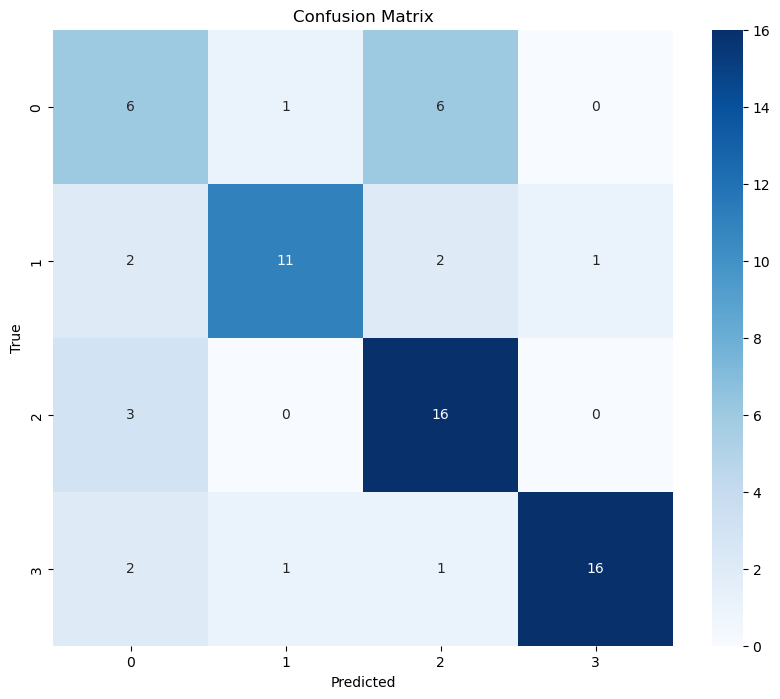

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


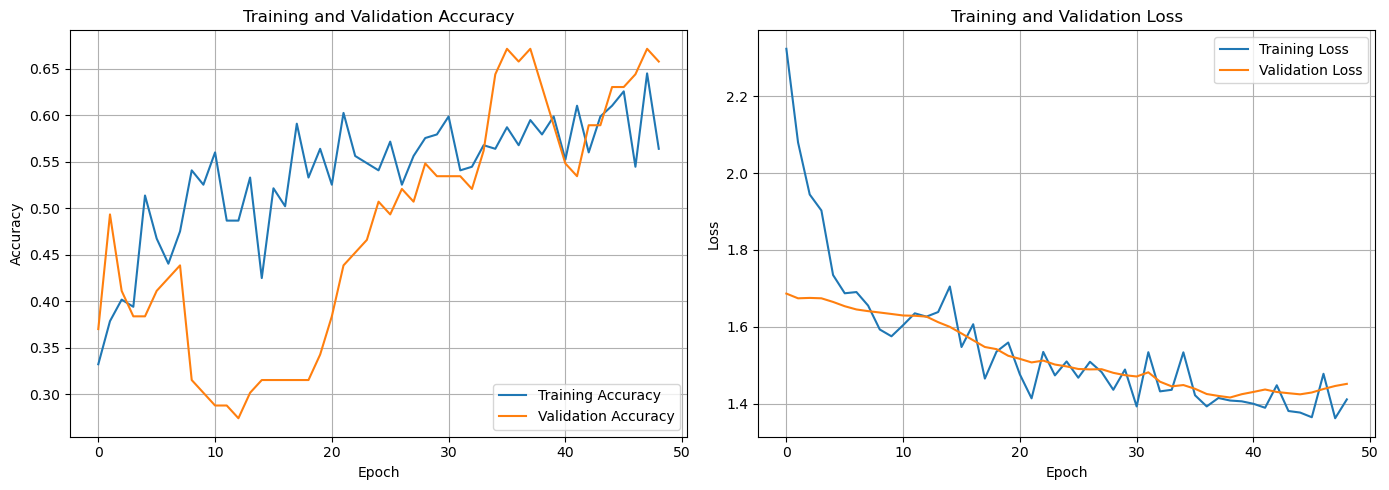

In [17]:
plot_training_history(history)
